In [6]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression


# Custom Functions

In [2]:
def compute_features(prices, freq='D'):
    """
    Compute HMM features: returns, volatility, momentum, trend, drawdown.
    freq: 'D' for daily, 'W' for weekly.
    """
    df = pd.DataFrame({'Close': prices})
    
    # 1. Log returns
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # 2. Volatility
    if freq == 'D':
        df['Volatility'] = df['LogReturn'].rolling(15).std()
    else:  # weekly
        df['Volatility'] = df['LogReturn'].rolling(13).std()
    
    # 3. Momentum (MA ratio)
    ma_short = 20 if freq == 'D' else 13
    ma_long = 60 if freq == 'D' else 26
    df['Momentum'] = df['Close'].rolling(ma_short).mean() / df['Close'].rolling(ma_long).mean() - 1
    
    # 4. Trend (regression slope)
    def regression_slope(series):
        y = series.values
        x = np.arange(len(y))
        if len(y) < 2:
            return np.nan
        slope = np.polyfit(x, y, 1)[0]
        return slope
    win = 60 if freq == 'D' else 26
    df['Trend'] = df['Close'].rolling(win).apply(regression_slope, raw=False)
    
    # 5. Drawdown from 6-month peak
    peak = df['Close'].rolling(126 if freq == 'D' else 26).max()
    df['Drawdown'] = (df['Close'] - peak) / peak
    
    return df.dropna()


In [3]:
def fit_hmm(features, n_states=3):
    """
    Fit an HMM and return model and scaler.
    """
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    model = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=500, random_state=42)
    model.fit(X_scaled)
    return model, scaler

def predict_states(model, scaler, features):
    """
    Predict HMM states from given features.
    """
    X_scaled = scaler.transform(features)
    return model.predict(X_scaled)

In [4]:
def backtest_hmm_strategy(prices, states, invest_states):
    """
    Backtest strategy: invest only when state is in invest_states.
    """
    df = pd.DataFrame({'Close': prices, 'State': states})
    df['Return'] = df['Close'].pct_change()
    df['Strategy'] = np.where(df['State'].shift(1).isin(invest_states), df['Return'], 0)
    df['EquityCurve'] = (1 + df['Strategy']).cumprod()
    return df

In [ ]:
def compute_metrics(strategy_df, periods_per_year=252):
    ret = strategy_df['Strategy']
    ann_ret = (1 + ret.mean())**periods_per_year - 1
    ann_vol = ret.std() * np.sqrt(periods_per_year)
    sharpe = ann_ret / ann_vol if ann_vol != 0 else np.nan
    downside = ret[ret < 0].std() * np.sqrt(periods_per_year)
    sortino = ann_ret / downside if downside != 0 else np.nan
    max_dd = (strategy_df['EquityCurve'] / strategy_df['EquityCurve'].cummax() - 1).min()
    return ann_ret, ann_vol, sharpe, sortino, max_dd

In [19]:
# --- Feature Engineering Functions ---

def compute_volatility(prices: pd.Series, window: int) -> pd.Series:
    """Rolling volatility (std dev of log returns)."""
    log_returns = np.log(prices / prices.shift(1))
    return log_returns.rolling(window).std()

def compute_momentum(prices: pd.Series, window: int) -> pd.Series:
    """Momentum via SMA ratio (price / SMA - 1)."""
    sma = prices.rolling(window).mean()
    return prices / sma - 1

def compute_trend(prices: pd.Series, window: int) -> pd.Series:
    """
    Trend via rolling regression slope of log prices.
    Slope is scaled to represent percentage change per period.
    """
    log_prices = np.log(prices)
    slopes = []
    x = np.arange(window).reshape(-1, 1)
    for i in range(len(prices)):
        if i < window:
            slopes.append(np.nan)
        else:
            y = log_prices.iloc[i-window+1:i+1].values.reshape(-1, 1)
            model = LinearRegression().fit(x, y)
            slopes.append(model.coef_[0][0])
    return pd.Series(slopes, index=prices.index)

def compute_drawdown(prices: pd.Series, window: int) -> pd.Series:
    """Drawdown relative to rolling peak over given window."""
    rolling_peak = prices.rolling(window).max()
    return prices / rolling_peak - 1

def add_features(prices: pd.Series, freq: str) -> pd.DataFrame:
    """
    Add log return plus volatility, momentum, trend, and drawdown for daily or weekly prices.
    freq: 'D' for daily, 'W' for weekly
    """
    df = pd.DataFrame({'Close': prices})
    
    # Log return (always included)
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    
    # Set rolling window lengths based on frequency
    if freq == 'D':
        vol_window = 15
        mom_window = 50
        trend_window = 50
        dd_window = 126  # ~6 months trading days
    elif freq == 'W':
        vol_window = 13
        mom_window = 26
        trend_window = 26
        dd_window = 26  # ~6 months weeks
    else:
        raise ValueError("freq must be 'D' or 'W'")
    
    # Other features
    df['Volatility'] = compute_volatility(df['Close'], vol_window)
    df['Momentum']   = compute_momentum(df['Close'], mom_window)
    df['Trend']      = compute_trend(df['Close'], trend_window)
    df['Drawdown']   = compute_drawdown(df['Close'], dd_window)
    
    return df.dropna()



In [16]:
def train_hmm_models(train_df, feature_sets, n_states=3):
    models = {}
    for name, features in feature_sets.items():
        X = train_df[features].dropna()
        model = GaussianHMM(n_components=n_states, covariance_type='full', random_state=23)
        model.fit(X)
        models[name] = {
            'model': model,
            'features': features
        }
    return models


In [28]:
def predict_no_leak(models, test_df, feature_sets):
    """
    Generate walk-forward predictions without leakage.
    Returns a DataFrame indexed by Date and Model.
    """
    all_preds = []

    for name, model in models.items():
        features = feature_sets[name]
        preds = []

        for i in range(len(test_df)):
            if i == 0:
                preds.append(np.nan)
                continue

            # Data up to the previous point (yesterday for daily, last week for weekly)
            past_data = test_df[features].iloc[:i].dropna()

            if past_data.empty:
                preds.append(np.nan)
                continue

            # Predict only for the last available row in past_data
            last_obs = past_data.tail(1)
            preds.append(model.predict(last_obs)[0])

        df_pred = pd.DataFrame({
            'Date': test_df.index,
            'Model': name,
            'PredictedState': preds
        })
        all_preds.append(df_pred)

    combined = pd.concat(all_preds)
    combined.set_index(['Date', 'Model'], inplace=True)
    return combined


# Load data

In [20]:
# --- Parameters ---
ticker = "^GSPC"  # S&P 500
start_date = "1995-01-01"
end_date = pd.Timestamp.today().strftime("%Y-%m-%d")
train_cutoff = "2025-04-30"

# --- Download Daily Close Prices ---
sp500 = yf.download(ticker, start=start_date, end=end_date, interval="1d")['Close']
sp500.name = "Close"

# --- Resample to Weekly (Friday close) ---
sp500_weekly = sp500.resample('W-FRI').last()

# --- Split into training and testing sets ---
sp500_train_daily = sp500.loc[:train_cutoff]
sp500_test_daily = sp500.loc[train_cutoff:]

sp500_train_weekly = sp500_weekly.loc[:train_cutoff]
sp500_test_weekly = sp500_weekly.loc[train_cutoff:]

# --- Summary ---
print("Daily prices:", sp500.index.min(), "→", sp500.index.max(), "Count:", len(sp500))
print("Weekly prices:", sp500_weekly.index.min(), "→", sp500_weekly.index.max(), "Count:", len(sp500_weekly))
print("\nTraining set (daily):", sp500_train_daily.index.min(), "→", sp500_train_daily.index.max(), "Count:", len(sp500_train_daily))
print("Testing set  (daily):", sp500_test_daily.index.min(), "→", sp500_test_daily.index.max(), "Count:", len(sp500_test_daily))
print("\nTraining set (weekly):", sp500_train_weekly.index.min(), "→", sp500_train_weekly.index.max(), "Count:", len(sp500_train_weekly))
print("Testing set  (weekly):", sp500_test_weekly.index.min(), "→", sp500_test_weekly.index.max(), "Count:", len(sp500_test_weekly))

C:\Users\User\AppData\Local\Temp\ipykernel_13484\3014188977.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download(ticker, start=start_date, end=end_date, interval="1d")['Close']
[*********************100%***********************]  1 of 1 completed


Daily prices: 1995-01-03 00:00:00 → 2025-07-29 00:00:00 Count: 7694
Weekly prices: 1995-01-06 00:00:00 → 2025-08-01 00:00:00 Count: 1596

Training set (daily): 1995-01-03 00:00:00 → 2025-04-30 00:00:00 Count: 7633
Testing set  (daily): 2025-04-30 00:00:00 → 2025-07-29 00:00:00 Count: 62

Training set (weekly): 1995-01-06 00:00:00 → 2025-04-25 00:00:00 Count: 1582
Testing set  (weekly): 2025-05-02 00:00:00 → 2025-08-01 00:00:00 Count: 14


# Feature Engineering

In [21]:
daily_features_train = add_features(sp500_train_daily['^GSPC'], 'D')
weekly_features_train = add_features(sp500_train_weekly['^GSPC'], 'W')

In [22]:
daily_features_train.head()

,Close,LogReturn,Volatility,Momentum,Trend,Drawdown
Date,,,,,,
1995-06-30,544.750000,0.001617,0.005974,0.029225,0.001350,-0.011469
1995-07-03,547.090027,0.004286,0.005930,0.032141,0.001331,-0.007222
1995-07-05,547.260010,0.000311,0.005544,0.031124,0.001326,-0.006914
1995-07-06,553.989990,0.012223,0.006204,0.042159,0.001341,0.000000
1995-07-07,556.369995,0.004287,0.006221,0.044918,0.001360,0.000000


In [30]:
# ✅ Create daily test features
daily_features_test = add_features(sp500_test_daily['^GSPC'], 'D')

# ✅ Create weekly test features
weekly_features_test = add_features(sp500_test_weekly['^GSPC'], 'W')


In [34]:
def add_features(prices: pd.Series, freq: str) -> pd.DataFrame:
    df = pd.DataFrame({'Close': prices})
    df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
    
    if freq == 'D':
        vol_window = 15
        mom_window = 50
        trend_window = 50
        dd_window = 126
    elif freq == 'W':
        vol_window = 13
        mom_window = 26
        trend_window = 26
        dd_window = 26
    else:
        raise ValueError("freq must be 'D' or 'W'")
    
    df['Volatility'] = compute_volatility(df['Close'], vol_window)
    df['Momentum']   = compute_momentum(df['Close'], mom_window)
    df['Trend']      = compute_trend(df['Close'], trend_window)
    df['Drawdown']   = compute_drawdown(df['Close'], dd_window)
    
    return df

sp500 = sp500.rename(columns={'^GSPC': 'Close'})

# 1️⃣ Compute features for all dates
daily_features_all = add_features(sp500['Close'], 'D')
weekly_features_all = add_features(sp500['Close'].resample('W-FRI').last(), 'W')

# 2️⃣ Split into train/test after features are computed
train_end = "2025-04-30"
daily_features_train = daily_features_all.loc[:train_end].dropna()
daily_features_test  = daily_features_all.loc["2025-05-01":].dropna()

weekly_features_train = weekly_features_all.loc[:train_end].dropna()
weekly_features_test  = weekly_features_all.loc["2025-05-01":].dropna()


# Train HMM Models

In [38]:
feature_sets = {
    'logret': ['LogReturn'],
    'logret_vol': ['LogReturn', 'Volatility'],
    'logret_mom': ['LogReturn', 'Momentum'],
    'logret_vol_mom': ['LogReturn', 'Volatility', 'Momentum'],
    'logret_vol_mom_trend': ['LogReturn', 'Volatility', 'Momentum', 'Trend'],
    'logret_vol_mom_trend_dd': ['LogReturn', 'Volatility', 'Momentum', 'Trend', 'Drawdown']
}


In [39]:
def train_hmm_models(train_df, feature_sets, n_states=3):
    models = {}
    for name, features in feature_sets.items():
        X = train_df[features].dropna()
        model = GaussianHMM(n_components=n_states, covariance_type='full', random_state=23)
        model.fit(X)
        models[name] = model
    return models

In [40]:
# Train daily models
daily_models = train_hmm_models(daily_features_train, feature_sets, n_states=3)

# Train weekly models
weekly_models = train_hmm_models(weekly_features_train, feature_sets, n_states=3)

c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(
c:\Users\User\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

# Evaluation

In [41]:
# Daily predictions
daily_predictions = predict_no_leak(daily_models, daily_features_test, feature_sets)

# Weekly predictions
weekly_predictions = predict_no_leak(weekly_models, weekly_features_test, feature_sets)

daily_predictions.head(), weekly_predictions.head()


(                   PredictedState
 Date       Model                 
 2025-05-01 logret             NaN
 2025-05-02 logret             0.0
 2025-05-05 logret             0.0
 2025-05-06 logret             0.0
 2025-05-07 logret             0.0,
                    PredictedState
 Date       Model                 
 2025-05-02 logret             NaN
 2025-05-09 logret             1.0
 2025-05-16 logret             1.0
 2025-05-23 logret             1.0
 2025-05-30 logret             1.0)

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


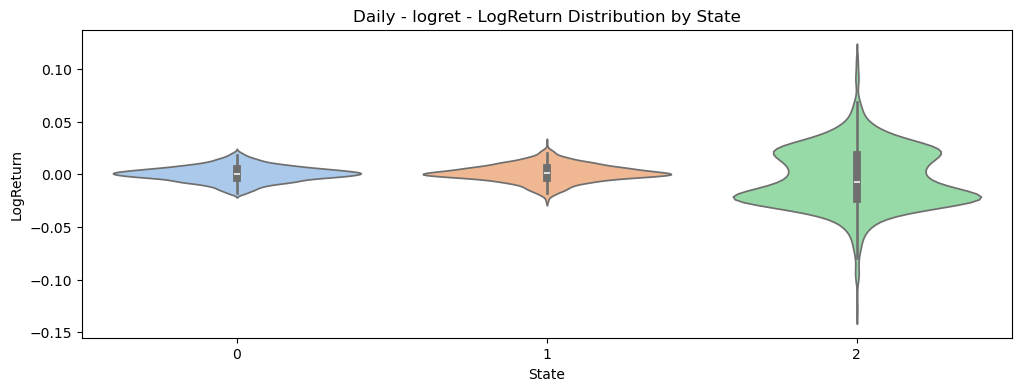

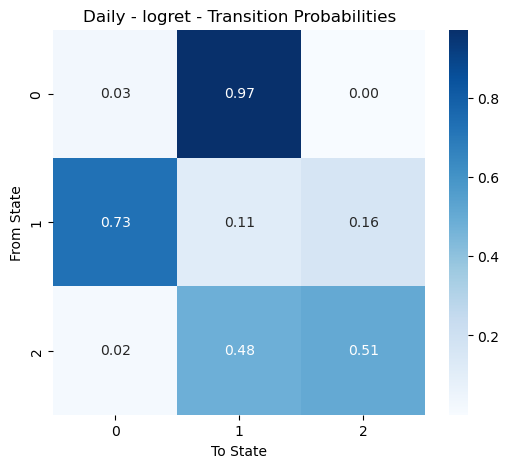

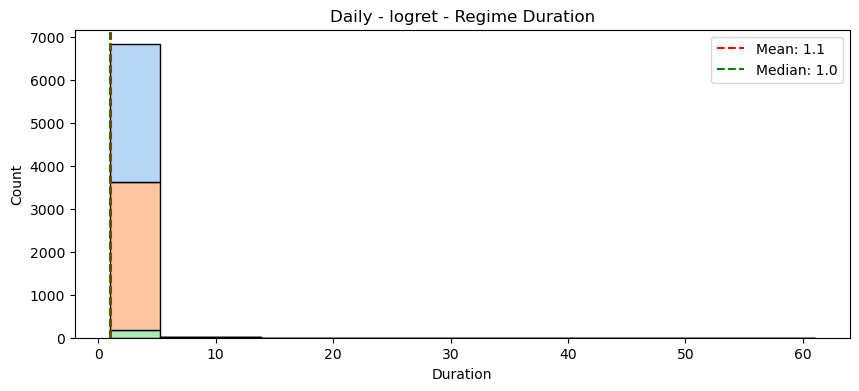

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


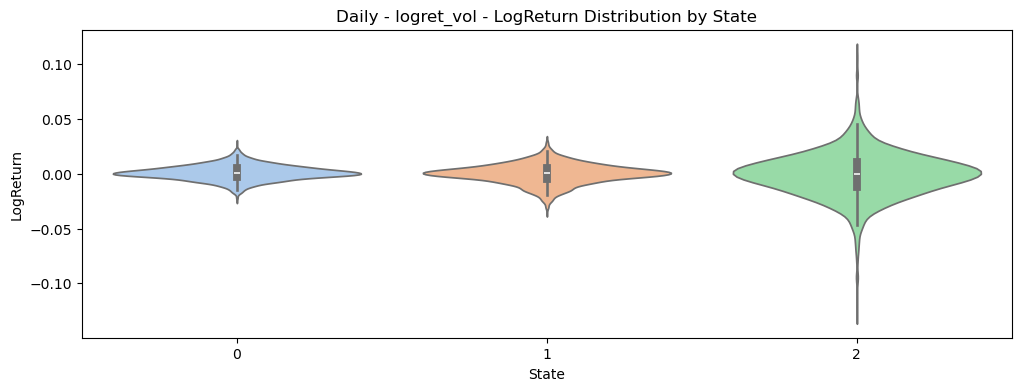

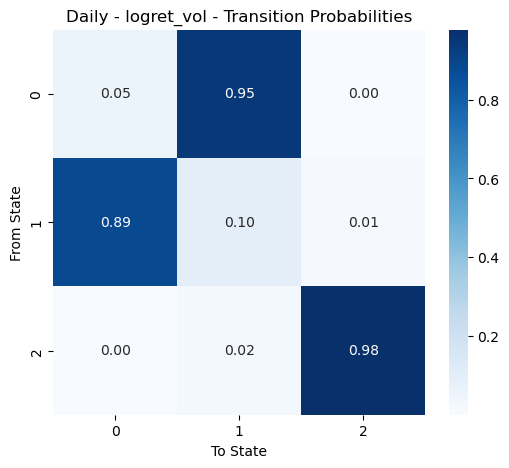

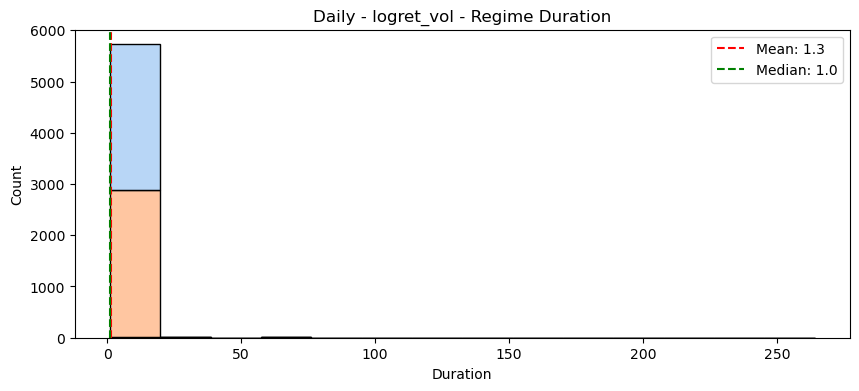

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


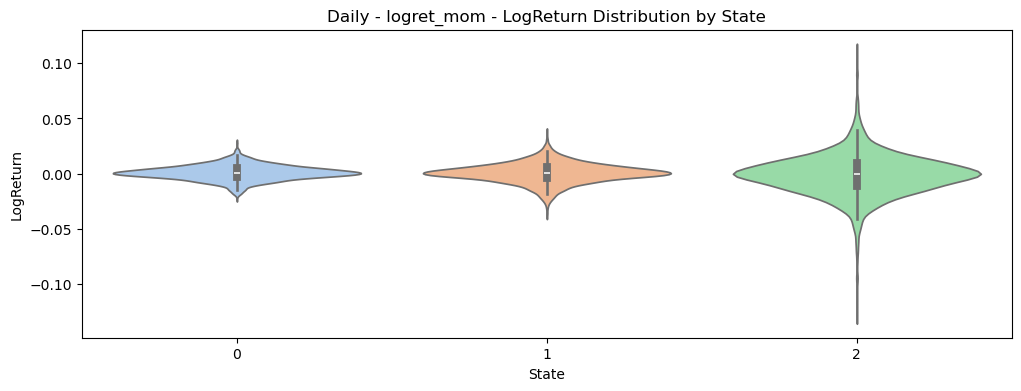

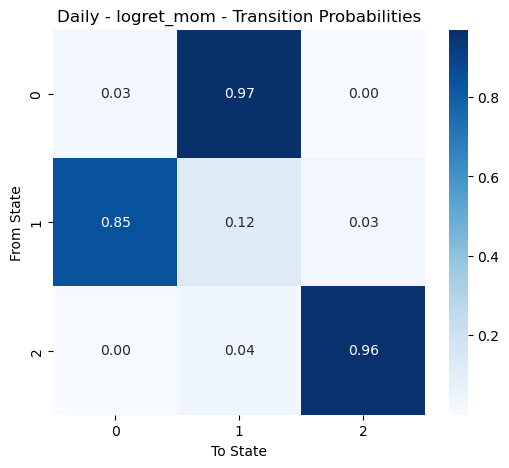

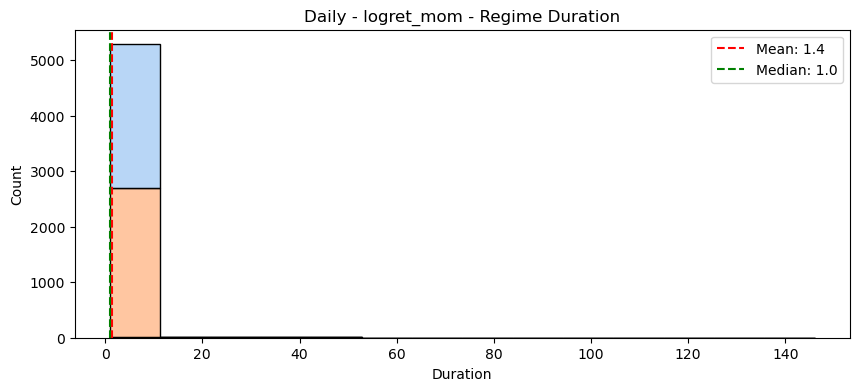

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


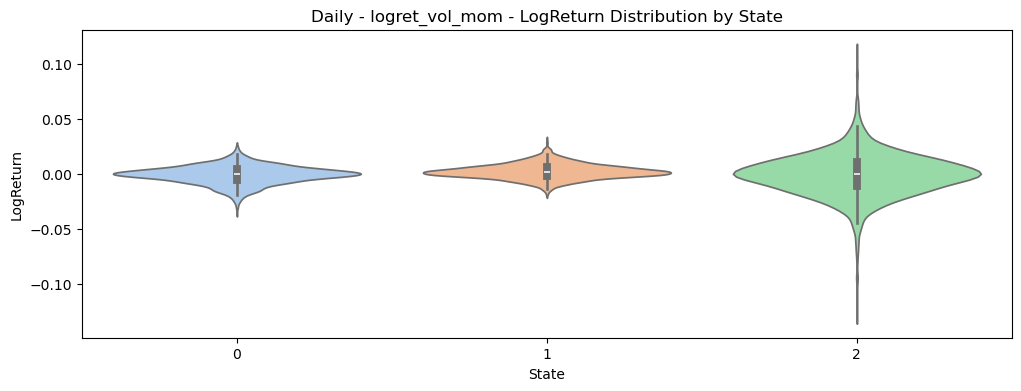

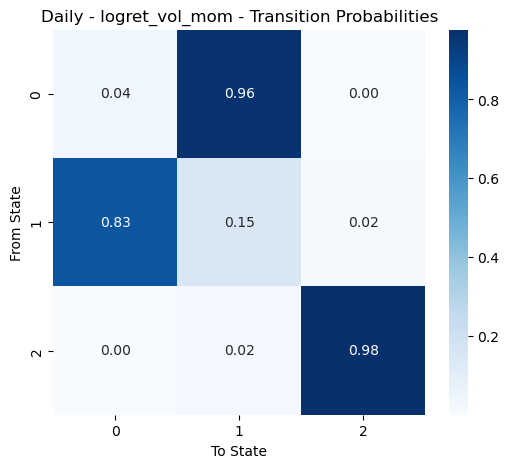

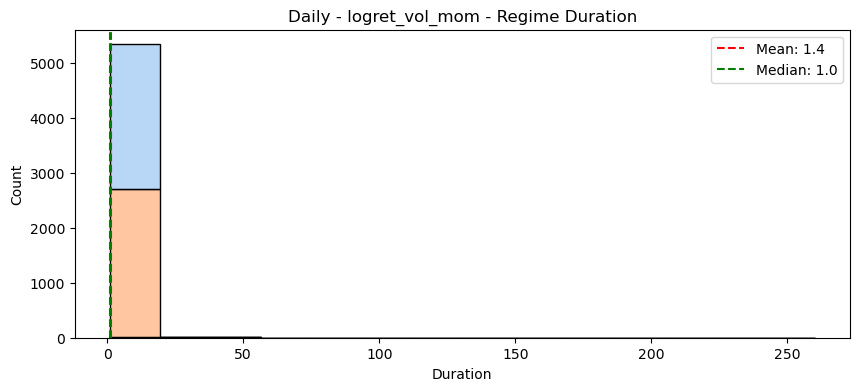

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


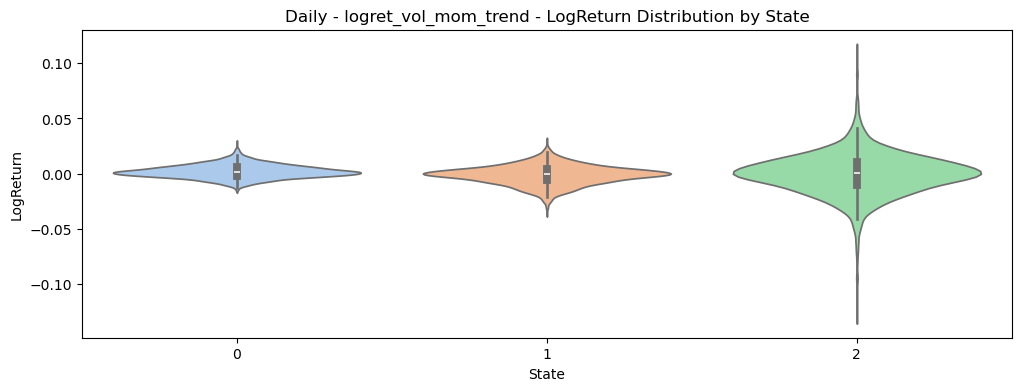

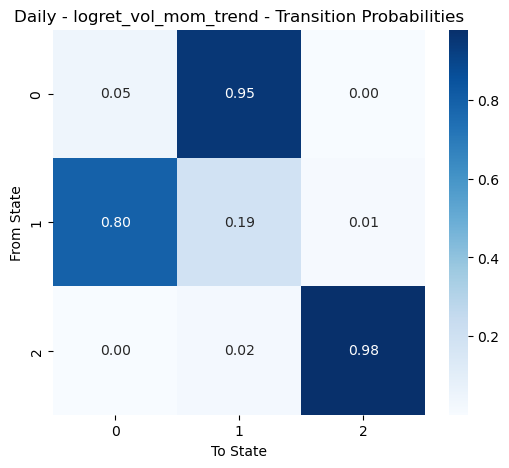

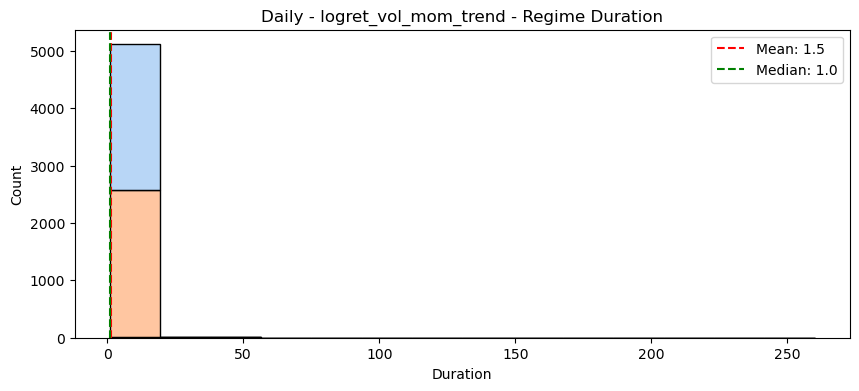

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


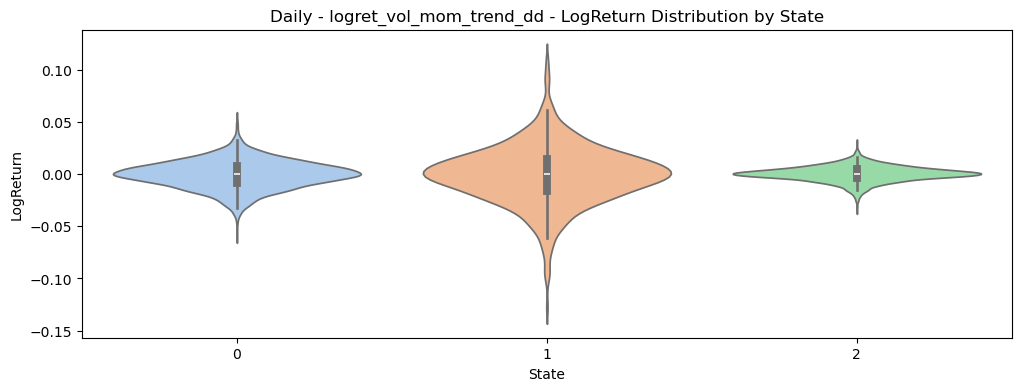

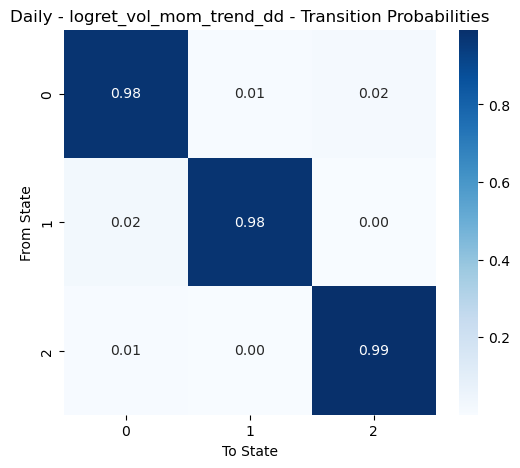

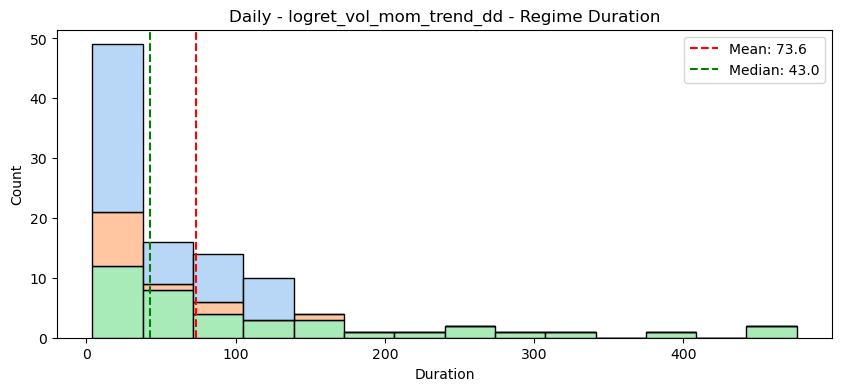

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


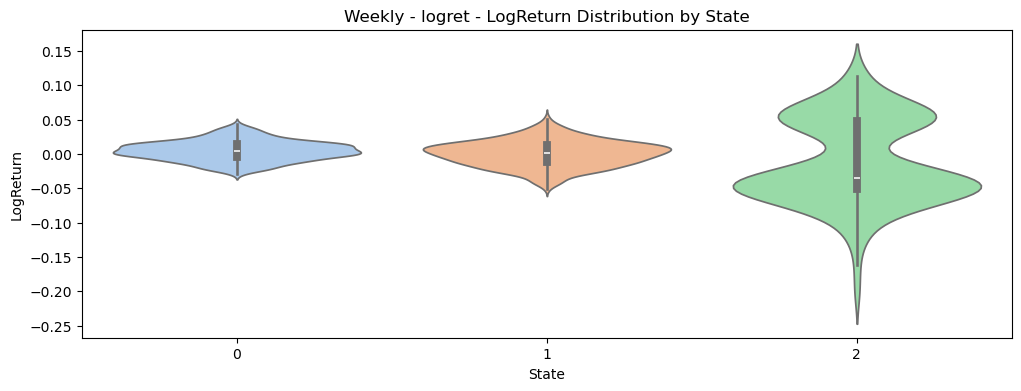

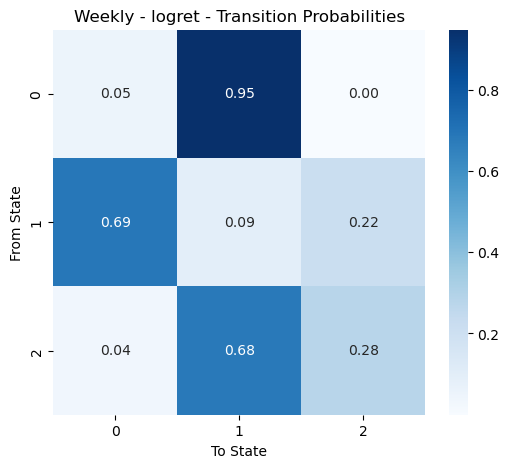

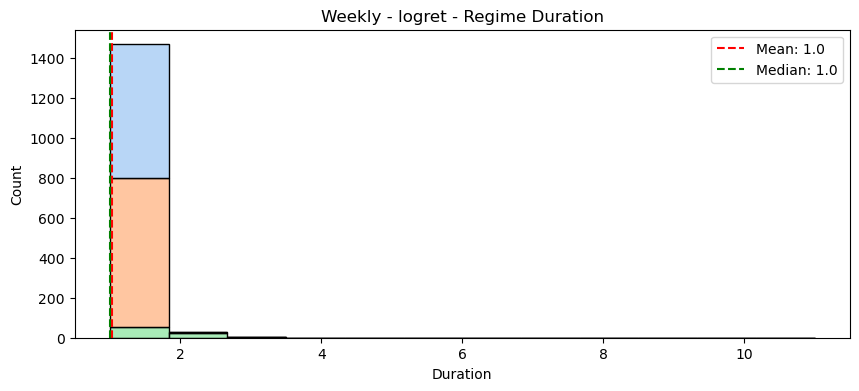

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


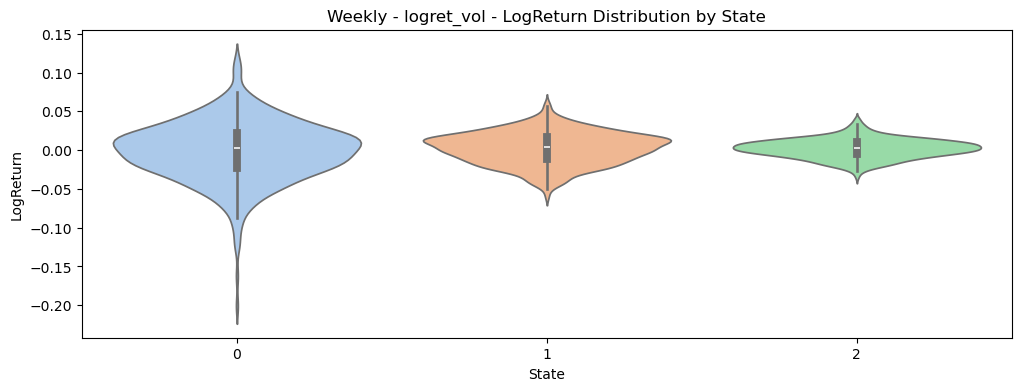

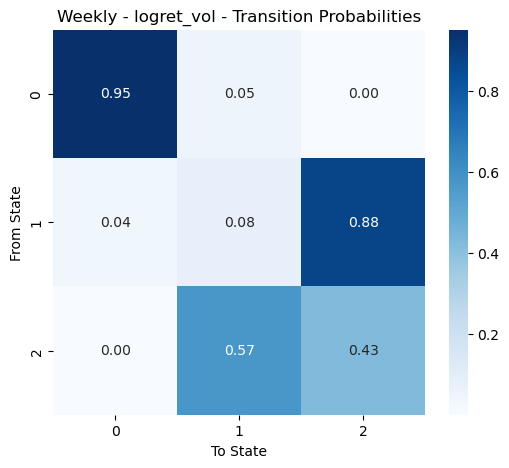

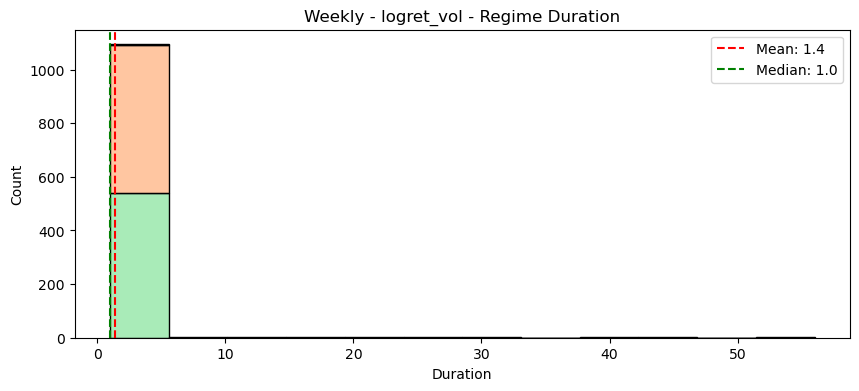

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


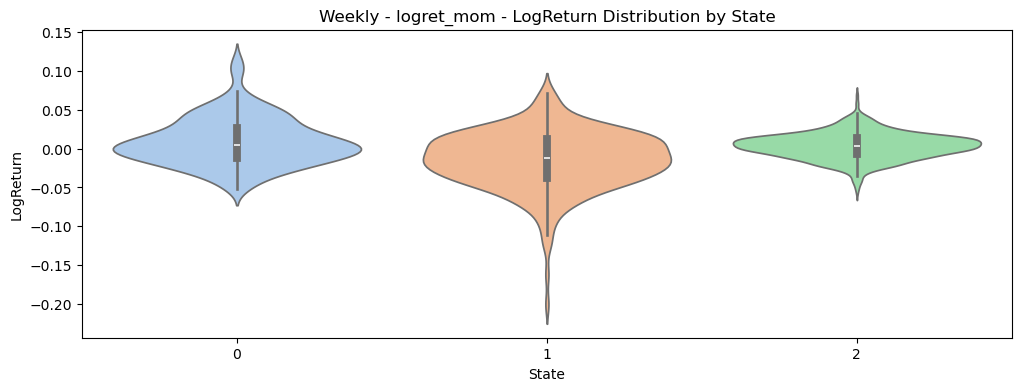

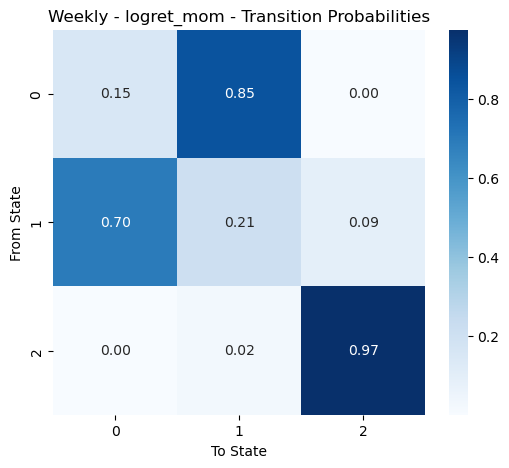

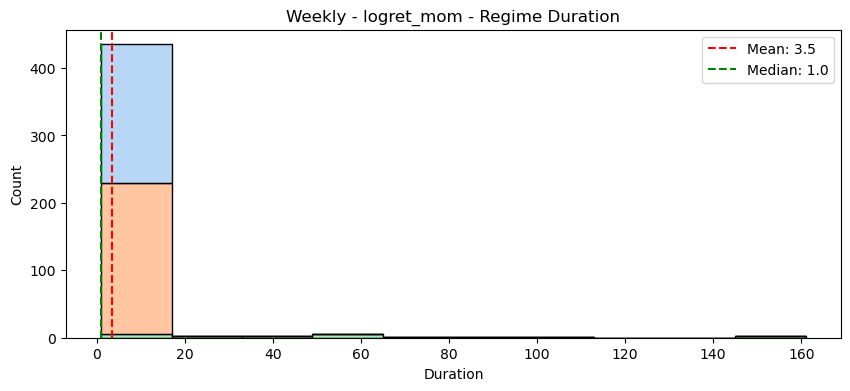

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


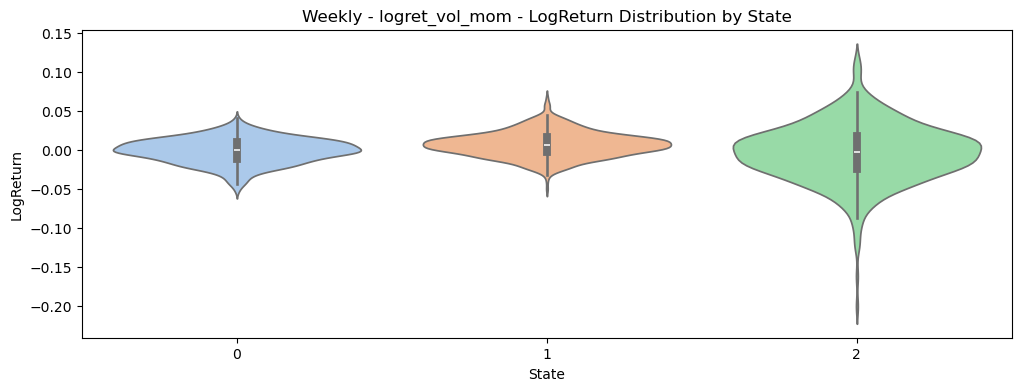

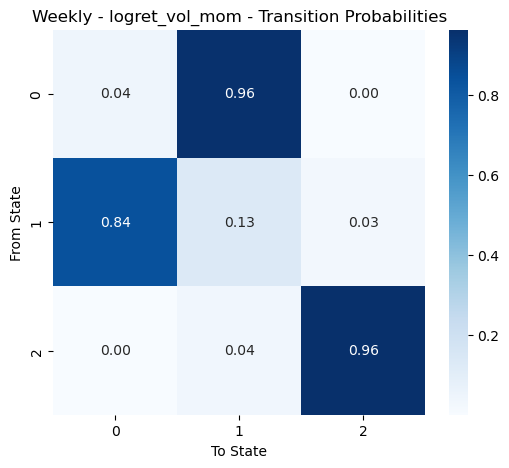

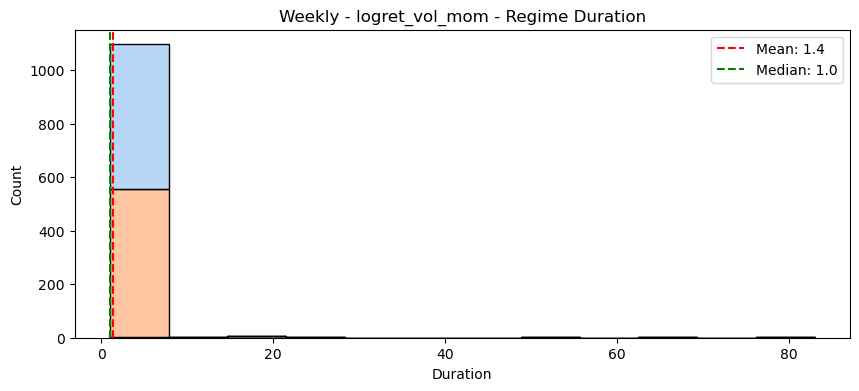

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


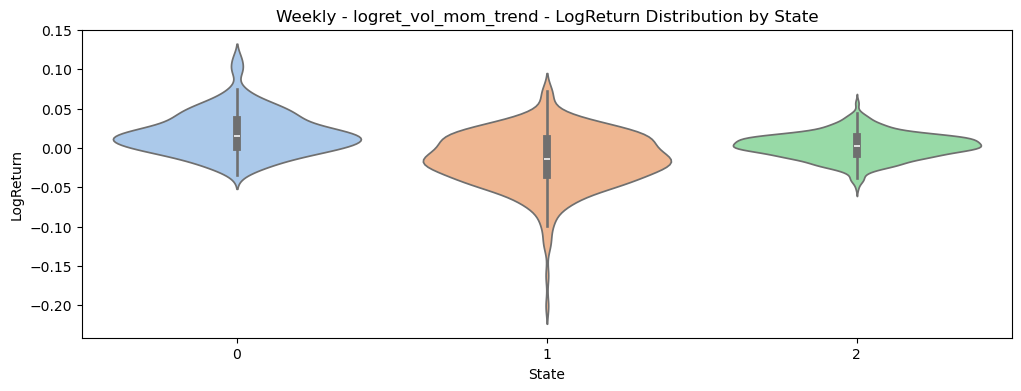

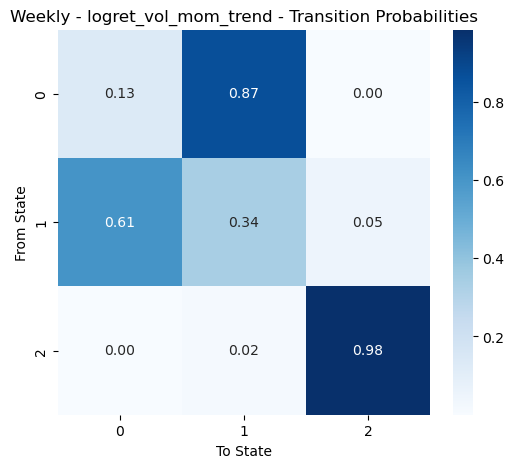

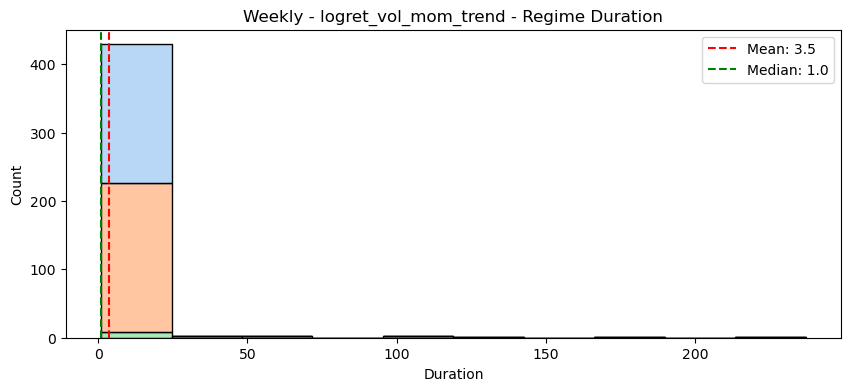

C:\Users\User\AppData\Local\Temp\ipykernel_13484\2805011600.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')


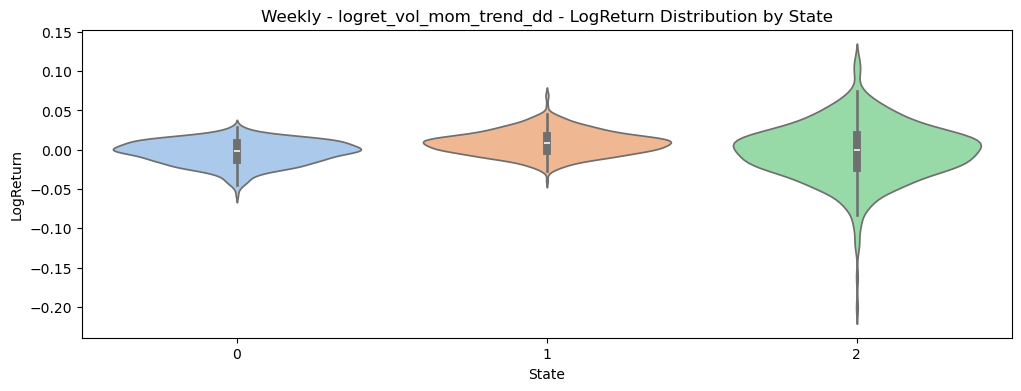

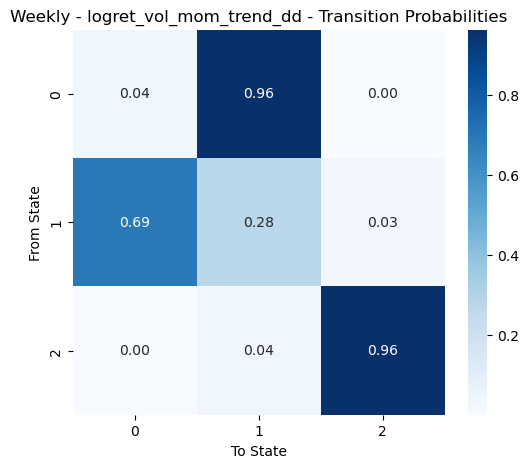

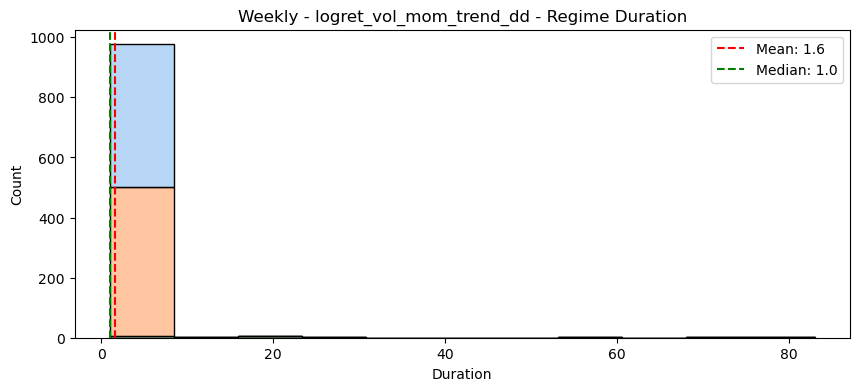

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def plot_model_analysis(model_name, model, features_df, feature_list):
    # --- Predict states ---
    X = features_df[feature_list].dropna()
    states = model.predict(X)
    
    df_pred = features_df.loc[X.index].copy()
    df_pred['State'] = states

    # --- Violin plot of log returns by regime ---
    plt.figure(figsize=(12, 4))
    sns.violinplot(data=df_pred, x='State', y='LogReturn', palette='pastel')
    plt.title(f"{model_name} - LogReturn Distribution by State")
    plt.show()

    # --- Transition probability matrix ---
    trans_matrix = model.transmat_
    plt.figure(figsize=(6, 5))
    sns.heatmap(trans_matrix, annot=True, fmt=".2f", cmap="Blues")
    plt.title(f"{model_name} - Transition Probabilities")
    plt.xlabel("To State")
    plt.ylabel("From State")
    plt.show()

    # --- Regime duration histogram ---
    durations = []
    current_state = None
    current_len = 0
    for s in states:
        if s == current_state:
            current_len += 1
        else:
            if current_state is not None:
                durations.append((current_state, current_len))
            current_state = s
            current_len = 1
    durations.append((current_state, current_len))

    durations_df = pd.DataFrame(durations, columns=['State', 'Duration'])
    plt.figure(figsize=(10, 4))
    sns.histplot(data=durations_df, x='Duration', hue='State', multiple='stack', palette='pastel')
    plt.axvline(durations_df['Duration'].mean(), color='red', linestyle='--', label=f"Mean: {durations_df['Duration'].mean():.1f}")
    plt.axvline(durations_df['Duration'].median(), color='green', linestyle='--', label=f"Median: {durations_df['Duration'].median():.1f}")
    plt.title(f"{model_name} - Regime Duration")
    plt.legend()
    plt.show()

# --- Run for all daily models ---
for name, model in daily_models.items():
    plot_model_analysis(f"Daily - {name}", model, daily_features_train, feature_sets[name])

# --- Run for all weekly models ---
for name, model in weekly_models.items():
    plot_model_analysis(f"Weekly - {name}", model, weekly_features_train, feature_sets[name])
